# CSE 252B: Computer Vision II, Winter 2023 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 8, 2023, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. If you are uncertain about using a specific package, then please ask the instructional staff whether or not it is allowable.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

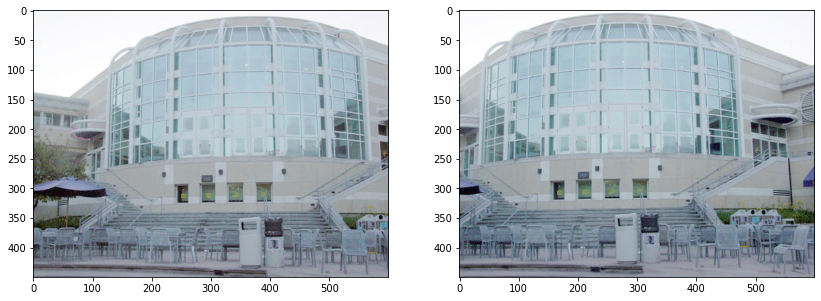

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.jpeg
contains image 1 and the file price_center21.jpeg contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

You may use scipy.signal.convolve to perform convolution operation and scipy.ndimage.maximum_filter for NMS operation.


You may either directly use the color images for feature detection, or use the color to grayscale mapping $Y = 0.21263903 * R + 0.71516871 * G + 0.072192319 * B$ to convert the images to grayscale first.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features

A typical implementation takes around <strong>30</strong> seconds to run. If yours takes more than <strong>60</strong> seconds, you may lose points.

In [2]:
from scipy import signal
from scipy import ndimage

def image_gradient(I):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    
    m, n = I.shape[:2]
       
    # Convert input to grayscale
    if m == 256 and n == 256:
        I_grayscale = I
    
    else:
        I_grayscale = 0.21263903 * I[:,:,0] + 0.71516871 * I[:,:,1] + 0.072192319 * I[:,:,2] 
    
    # Initialize Ix and Iy
    Ix = np.zeros((m, n))
    Iy = np.zeros((m, n))
    
    # Initialize weight w
    w = np.array([-1/12, 8/12, 0, -8/12, 1/12])
    
    # Derivative in 1D using 5-point central difference and convolution
    for i in range(2, m-2):
        for j in range(2, n-2):
            Ix[i,j] = signal.convolve(I_grayscale[i, j-2:j+3], w, mode = 'valid', method = 'direct')
            Iy[i,j] = signal.convolve(I_grayscale[i-2:i+3, j], w.T, mode = 'valid', method = 'direct')

    return Ix, Iy
  

def minor_eigenvalue_image(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    # Calculate minor eigenvalue image J0
    
    pad = int((w-1)/2)
    
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Shi-Tomasi corner detector algorithm
    for i in range(pad, m - pad):
        for j in range(pad, n - pad):
            M = np.array([ [np.sum(Ixx[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1])], [np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Iyy[i-pad:i+pad+1, j-pad:j+pad+1])] ])
            
            J0[i,j] = ( np.trace(M) - np.sqrt( max( 0, (np.trace(M)**2 - 4*np.linalg.det(M)) ) ) )/2


    return J0
  
def nms(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    J2 = J.copy()
    
    m, n  = J2.shape[:2]
    
    R_max = ndimage.maximum_filter(J, size = w_nms)
    
    for i in range(m):
        for j in range(n):
            if J2[i,j] < R_max[i,j]:
                J2[i,j] = 0
    
    return J2
  
def forstner_corner_detector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))

    # Calculation of minor eigenvalue image J0
    J0 = minor_eigenvalue_image(Ix, Iy, w)
    
    # Calculation of thresholded version J1
    for i in range(m):
        for j in range(n):
            if J0[i,j] > t:
                J1[i,j] = J0[i,j]
                
    # Run non-maxima suppression on thresholded minor eigenvalue image
    J2 = nms(J1, w_nms)
    
    # Detect corners
    
    pad = int((w-1)/2)
    C   = np.count_nonzero(J2)
    pts = np.zeros((2, C))
    _c  = 0
    
    x   = np.array([[i for i in range(n)] for j in range(m)])
    y   = np.array([[j for i in range(n)] for j in range(m)])
    
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    xIxx = x * Ixx
    xIxy = x * Ixy
    yIxy = y * Ixy
    yIyy = y * Iyy
    
    # Calculate coordinates of corner point in window using Forstner detection algorithm
    
    for i in range(m):
        for j in range(n):
            if J2[i,j] != 0:
                A = np.array([ [np.sum(Ixx[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1])], [np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(Iyy[i-pad:i+pad+1, j-pad:j+pad+1])] ])
                B = np.array([ np.sum(xIxx[i-pad:i+pad+1, j-pad:j+pad+1] + yIxy[i-pad:i+pad+1, j-pad:j+pad+1]), np.sum(xIxy[i-pad:i+pad+1, j-pad:j+pad+1] + yIyy[i-pad:i+pad+1, j-pad:j+pad+1]) ])
                pts[:, _c] = (np.linalg.inv(A) @ B)
                _c += 1

    
    return C, pts, J0, J1, J2


# feature detection
def run_feature_detection(I, w, t, w_nms):
    Ix, Iy = image_gradient(I)
    C, pts, J0, J1, J2 = forstner_corner_detector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [3]:
# ImageGradient() unit test
def check_values(I, target):
    eps = 1e-8  # Floating point error threshold
    I = I[2:-2, 2:-2]  # Ignore border values
    valid = np.all((I < target + eps) & (I > target - eps))
    print(f'Image is all equal to {target} +/- {eps}: {valid}')
    
def gray_to_RGB(I):
    h, w = I.shape
    I = np.expand_dims(I, axis=-1)
    return np.broadcast_to(I, (h, w, 3))

rampx = np.array(Image.open('rampx.png'), dtype='float')
rampy = np.array(Image.open('rampy.png'), dtype='float')

# If you are using grayscale images in ImageGradient(), comment out these lines 
# rampx = gray_to_RGB(rampx)
# rampy = gray_to_RGB(rampy)

# rampx_Ix should be all ones, rampx_Iy should be all zeros (to floating point error)
rampx_Ix, rampx_Iy = image_gradient(rampx) 
check_values(rampx_Ix, 1)
check_values(rampx_Iy, 0)

# rampy_Ix should be all zeros, rampx_Iy should be all ones (to floating point error)
rampy_Ix, rampy_Iy = image_gradient(rampy)
check_values(rampy_Ix, 0)
check_values(rampy_Iy, 1)

Image is all equal to 1 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 1 +/- 1e-08: True


took 31.977775 secs


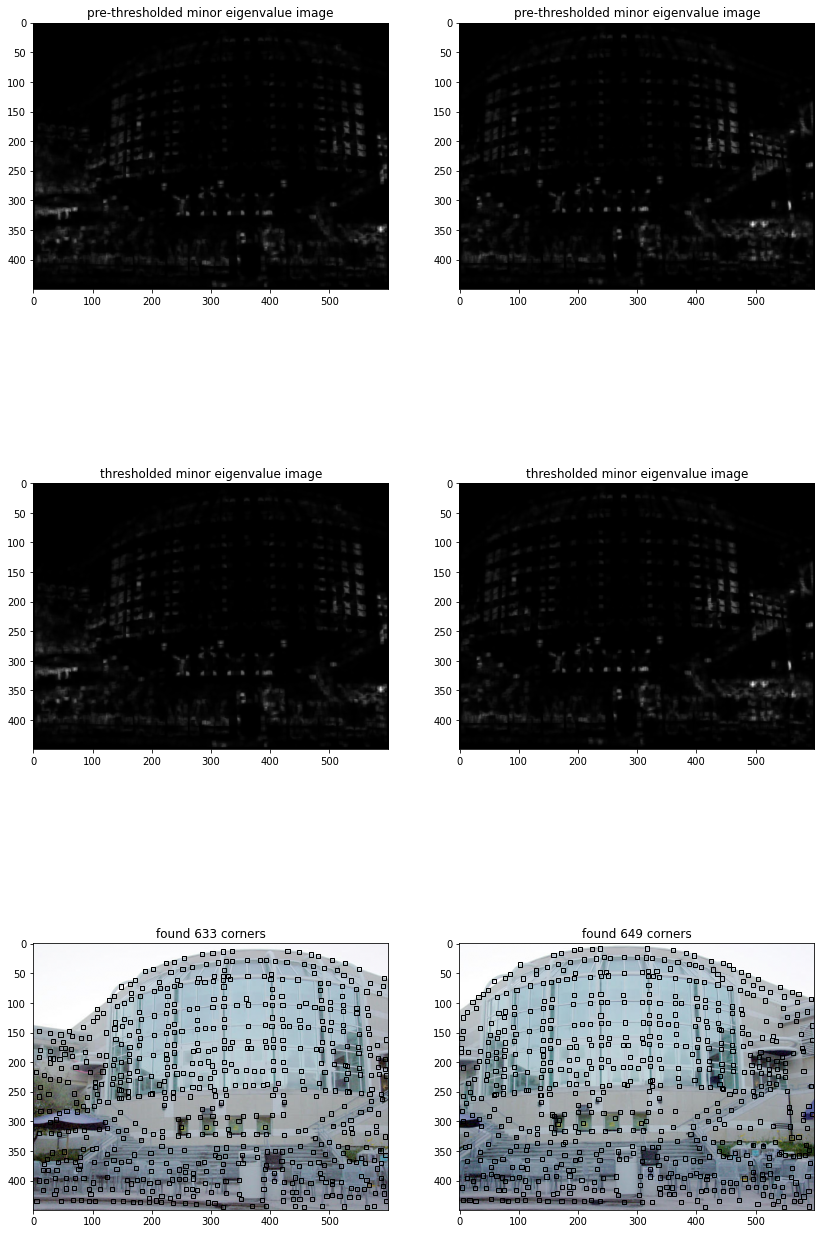

In [4]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 7
t = 0.0025
w_nms = 11

tic = time.time()
# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = run_feature_detection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = run_feature_detection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show pre-thresholded minor eigenvalue images
plt.subplot(3,2,1)
plt.imshow(J1_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')
plt.subplot(3,2,2)
plt.imshow(J2_0, cmap='gray')
plt.title('pre-thresholded minor eigenvalue image')

# show thresholded minor eigenvalue images
plt.subplot(3,2,3)
plt.imshow(J1_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')
plt.subplot(3,2,4)
plt.imshow(J2_1, cmap='gray')
plt.title('thresholded minor eigenvalue image')

# show corners on original images
ax = plt.subplot(3,2,5)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(3,2,6)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 7
* t = 0.0025
* w_nms = 11
* C1 = 633
* C2 = 649

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that 160-240 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

Use the following formula to calculate the correlation coefficient (normalized cross correlation) between two image windows $I_1$ and $I_2$:
$$\frac{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right] \left[ I_2(x, y) - \overline{I_2} \right] }{\sqrt{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right]^2 \cdot \sum_{x, y}\left[ I_2(x, y) - \overline{I_2} \right]^2}}$$

where $I(x, y)$ is the pixel value of $I$ at $(x, y)$ and $\overline{I}$ is the mean value of $I$.

**Note: You must center each window at the sub-pixel corner coordinates while computing normalized cross correlation, i.e., you must use bilinear interpolation to compute the pixel values at non-integer coordinates; otherwise, you will lose points.**

You may use scipy.interpolate.RegularGridInterpolator to perform bilinear interpolation.


#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e., matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature. 

(You must use original (color) images to the draw boxes and correspondence lines)

A typical implementation takes around 10 seconds to run. If yours takes more than 120 seconds, you may lose points.


In [5]:
def compute_ncc(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates 
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    # 
        
    # Convert input to grayscale
    I1_gray = 0.21263903 * I1[:,:,0] + 0.71516871 * I1[:,:,1] + 0.072192319 * I1[:,:,2] 
    I2_gray = 0.21263903 * I2[:,:,0] + 0.71516871 * I2[:,:,1] + 0.072192319 * I2[:,:,2] 
    
    c1 = pts1.shape[1]
    c2 = pts2.shape[1]
    m, n = I1.shape[:2]
    
    scores = -1 * np.ones((c1, c2))
    pad = int((w-1)/2)
    
    # Compute normalized cross correlation matrix of scores after nominal bilinear interpolation
    for i in range(c1):
        for j in range(c2):
            pt1 = pts1[:,i].astype(int)
            pt2 = pts2[:,j].astype(int)
    
            if np.linalg.norm(pt1 - pt2) < p:
                x1_min = pt1[1] - pad
                x1_max = pt1[1] + pad
                y1_min = pt1[0] - pad
                y1_max = pt1[0] + pad
                
                x2_min = pt2[1] - pad
                x2_max = pt2[1] + pad
                y2_min = pt2[0] - pad
                y2_max = pt2[0] + pad
                
                if x1_min > 0 and y1_min > 0 and x1_max < m and y1_max < n:
                    if x2_min > 0 and y2_min > 0 and x2_max < m and y2_max < n:
                        win1 = I1_gray[x1_min:x1_max, y1_min:y1_max]
                        win2 = I2_gray[x2_min:x2_max, y2_min:y2_max]
                        scores[i,j] = np.sum( (win1 - np.mean(win1)) * (win2 - np.mean(win2)) ) / np.sqrt( np.sum( np.square(win1 - np.mean(win1)) ) * np.sum( np.square(win2 - np.mean(win2)) ) )                  

                        
    return scores


def perform_match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ratio threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    
    inds        = np.zeros((2, 250))
    
    temp_scores = np.copy(scores) # mask
    
    max_value   = np.max(temp_scores)

    i = 0
    
    # Loop for feature matching algorithm
    while t <= max_value:
        index = np.where(temp_scores == max_value)
        
        scores[index[0][0], index[1][0]] = -1 
        
        next_max_value = max( np.max(scores[index[0][0], :]), np.max(scores[:, index[1][0]]) )
        
        scores[index[0][0], index[1][0]] = max_value
        
        if (1 - max_value) < (1 - next_max_value)*d:
            inds[0,i] = index[0][0]
            inds[1,i] = index[1][0]
            i = i + 1
            
        temp_scores[index[0][0], :] = -1
        temp_scores[:, index[1][0]] = -1
        
        max_value = np.max(temp_scores)

    inds = inds[:,~np.all(inds == 0, axis = 0)]
    
    return inds


def run_feature_matching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = compute_ncc(I1, I2, pts1, pts2, w, p)
    inds = perform_match(scores, t, d)
    return inds

took 10.260926 secs


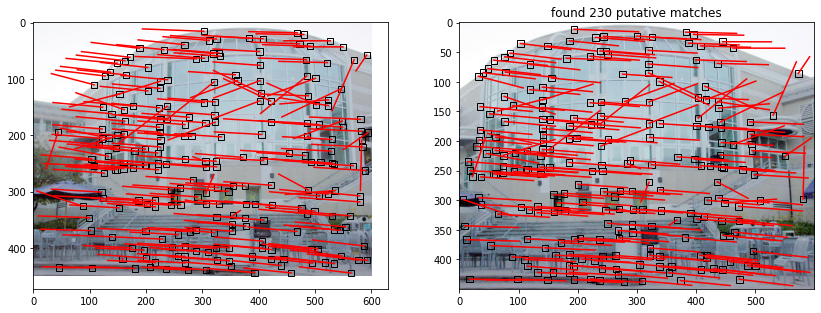

unique points in image 1: 230
unique points in image 2: 230


In [6]:
# parameters to tune
w = 11
t = 0.75
d = 0.9
p = 120

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = run_feature_matching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]

# display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# test 1-1
print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 11
* t = 0.75
* d = 0.9
* p = 120
* num_matches = 230

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error. There must be at least **150 inlier correspondences**.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


took 0.231040 secs
10 iterations
inlier count:  181
inliers:  [0, 2, 4, 6, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 56, 57, 58, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 88, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 134, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 157, 159, 160, 161, 162, 163, 164, 166, 167, 168, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 186, 187, 188, 189, 190, 192, 193, 195, 196, 198, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 215, 216, 217, 218, 219, 221, 223, 224, 226, 228, 229]
MSAC Cost=363.463939063
H_MSAC =
[[ 1.10072682e-02 -4.37782851e-06 -9.83395227e-01]
 [ 3.21826071e-04  1.07617587e-0

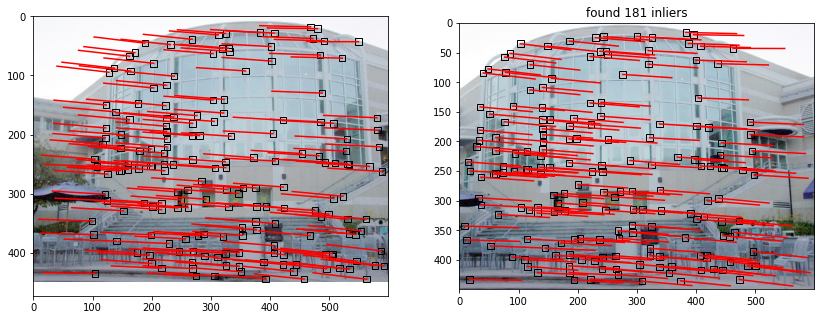

In [10]:
from scipy.stats import chi2

def display_results(H, title):
    print(title+' =')
    print (H/np.linalg.norm(H)*np.sign(H[-1,-1]))

def homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

def compute_MSAC_cost(H,x1,x2,tol):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix 
    # tol - tolerance for establishing datum/model compatibility
    #
    # Output:
    # cost - Squared sampson error
    
    error   = np.zeros(x1.shape[1])
    x1      = homogenize(x1)
    
    cost    = 0
    
    for i in range(x1.shape[1]):
        epsilon    = np.zeros((2, 1))
        J          = np.zeros((2, 4))
        
        epsilon[0] = -x1[:,i] @ H[1] + x2[1,i] * x1[:,i] @ H[2]
        epsilon[1] = x1[:,i] @ H[0] - x2[0,i] * x1[:,i] @ H[2]
        
        J[0,0]     = -H[1,0] + x2[1,i] * H[2,0]
        J[0,1]     = -H[1,1] + x2[1,i] * H[2,1]
        J[0,3]     = x1[0,i] * H[2,0] + x1[1,i] * H[2,1] + H[2,2]
        J[1,0]     = H[0,0] - x2[0,i] * H[2,0]
        J[1,1]     = H[0,1] - x2[0,i] * H[2,1]
        J[1,2]     = -(x1[0,i] * H[2,0] + x1[1,i] * H[2,1] + H[2,2])
        
        error[i]   = epsilon.T @ np.linalg.inv(J @ J.T) @ epsilon
        
        if error[i] <= tol:
            cost = cost + error[i]
            
        else:
            cost = cost + tol
 
    return error, cost

def minimal_solver(pts):
    # Inputs:
    #   pts       - Randomly selected 4 homogenous image points
    
    # Outputs:
    #   H_SB_inv  - Inverse of 2D projective transformation matrix
    
    # Calculation of 2D projective transformation, 4 points to standard basis
    
    A        = np.hstack((pts[:,0].reshape(3,1), pts[:,1].reshape(3,1)))
    A        = np.hstack((A, pts[:,2].reshape(3,1)))
    
    lam      = np.linalg.solve(A, pts[:,3].reshape(3,1))
    
    H_SB_inv = np.hstack((lam[0] * pts[:,0].reshape(3,1), lam[1] * pts[:,1].reshape(3,1)))
    H_SB_inv = np.hstack((H_SB_inv, lam[2] * pts[:,2].reshape(3,1)))
  
    return H_SB_inv

def calculate_num_inliers(error, tol):
    # Inputs:
    #    error  - Squared sampson error
    #    tol    - reprojection error tolerance 
    #
    # Output:
    #    count  - Inlier count
    
    count = 0
    
    for i in range(len(error)):
        if error[i] <= tol:
            count = count + 1
    
    return count
    

def determine_inliers(pts1, pts2, thresh, tol, p):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    # Initialization of all variables
    trials                   = 0
    max_trials               = np.inf
    consensus_min_cost       = np.inf
    tau_cost                 = 0
    sample_size              = 4
    consensus_min_cost_model = np.zeros((3,3))
    
    # Loop
    
    while trials < max_trials and consensus_min_cost > tau_cost:
    
        # Randomly sample 4 data points from each image
        indices          = np.random.choice(pts1.shape[1], sample_size, replace = False)
    
        x1_i             = homogenize(pts1[:, indices])
        x2_i             = homogenize(pts2[:, indices])

        # Compute H for transformation of 4 points in image 1 to 4 points in image 2
        # using 4 points minimal solver
        H1_SB_inv        = minimal_solver(x1_i)
        H2_SB_inv        = minimal_solver(x2_i)
        H                = H2_SB_inv @ np.linalg.inv(H1_SB_inv)
       
        # Calculate error for each data point using model and total cost
        error, cost      = compute_MSAC_cost(H, pts1, pts2, tol)
        
        # Calculate number of inliers using model 
        if cost < consensus_min_cost:
            consensus_min_cost       = cost
            consensus_min_cost_model = H
            num_inliers              = calculate_num_inliers(error, tol)
            w                        = num_inliers / pts1.shape[1]
            max_trials               = (np.log(1 - p)) / (np.log(1 - w**sample_size))
                        
        trials = trials + 1
    
    # Calculate error using the consensus_min_cost_model and set of inliers
    error, _ = compute_MSAC_cost(consensus_min_cost_model, pts1, pts2, tol)
    inliers  = []
    
    for i in range( pts1.shape[1]):
        if error[i] <= tol:
            inliers.append(i)

    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh      = 0
codimension = 2
p           = 0.99
alpha       = 0.95
tol         = chi2.ppf(alpha, df = codimension)

tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = determine_inliers(match1, match2, thresh, tol, p)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
display_results(H_MSAC, 'H_MSAC')

# display the figures
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d inliers'%xin1.shape[1])
for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

#### Final values for parameters
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 5.9914
* threshold = 0
* num_inliers = 181
* num_attempts = 10

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [11]:
from scipy.linalg import null_space

def data_normalize(pts):
    # Input:
    # pts - 2D scene points
    #
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    
    # Calculate mean and variance for the scene points
    mu_x = np.mean(pts[0, :])
    mu_y = np.mean(pts[1, :])

    sigma_x = np.std(pts[0, :])
    sigma_y = np.std(pts[1, :])
    
    # Calculate s
    s = np.sqrt(2 / (sigma_x**2 + sigma_y**2))
    
    # Formulate Transformation matrix
    T = np.identity(3)
    T[0,0] = T[1,1] = s
    T[0,2] = -s * mu_x
    T[1,2] = -s * mu_y
    
    # Homogenize points
    pts = homogenize(pts)
    
    # Data normalize the points
    pts = T @ pts
    
    return pts, T

def compute_sampson_cost(H,x1,x2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix 
    #
    # Output:
    # cost - Squared sampson error
    
    x1      = homogenize(x1)
    
    cost    = 0
    
    for i in range(x1.shape[1]):
        epsilon    = np.zeros((2, 1))
        J          = np.zeros((2, 4))
        
        epsilon[0] = -x1[:,i] @ H[1] + x2[1,i] * x1[:,i] @ H[2]
        epsilon[1] = x1[:,i] @ H[0] - x2[0,i] * x1[:,i] @ H[2]
        
        J[0,0]     = -H[1,0] + x2[1,i] * H[2,0]
        J[0,1]     = -H[1,1] + x2[1,i] * H[2,1]
        J[0,3]     = x1[0,i] * H[2,0] + x1[1,i] * H[2,1] + H[2,2]
        J[1,0]     = H[0,0] - x2[0,i] * H[2,0]
        J[1,1]     = H[0,1] - x2[0,i] * H[2,1]
        J[1,2]     = -(x1[0,i] * H[2,0] + x1[1,i] * H[2,1] + H[2,2])
        
        cost       = cost + epsilon.T @ np.linalg.inv(J @ J.T) @ epsilon
    
    return cost

def estimate_2D_projective_transformation_linear(x1, x2, normalize=True):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - Sampson cost for the above DLT Estimate H. Assume points in image 1 as scene points.
       
    # data normalization
    if normalize:
        print('normalize')
        x1_DN, T1 = data_normalize(x1)
        x2_DN, T2 = data_normalize(x2)
    
    else:
        x1_DN = homogenize(x1)
        x2_DN = homogenize(x2)
    
    v       = np.zeros((x2_DN.shape))
    e1      = np.zeros((x2_DN.shape))
    A       = np.zeros((2*x2_DN.shape[1], 3*x1_DN.shape[0]))
    I       = np.identity(3)
    e1[0,:] = 1
        
    norm_x2 = np.linalg.norm(x2_DN, axis = 0)
    
    # Calculation of left null space of a vector 
    # 2D point at intersection of two 2D lines
    
    for i in range(v.shape[1]):
        if x2_DN[0,i] > 0:
            v[:,i] = x2_DN[:,i] + norm_x2[i] * e1[:,i]
            
        elif x2_DN[0,i] < 0:
            v[:,i] = x2_DN[:,i] - norm_x2[i] * e1[:,i]
    
    # Linear estimation of H using DLT Algorithm
    for i in range(v.shape[1]):
        H_v         = I - 2 * ( (v[:,i].reshape(3,1) @ v[:,i].reshape(1,3)) / (v[:,i] @ v[:,i].T) )
        x_ortho     = H_v[1:, :]
        A[2*i, :]   = np.kron(x_ortho[0,:], x1_DN[:,i])
        A[2*i+1, :] = np.kron(x_ortho[1,:], x1_DN[:,i])
    
    # Solution vector H and corresponding matrix form
    _, _, V = np.linalg.svd(A)
    
    H = V[-1, :].reshape(3,3)
    
    # data denormalize
    if normalize:
        print('denormalize')
        
        H = np.linalg.inv(T2) @ H @ T1
        
    cost = compute_sampson_cost(H, x1, x2)
       
    return H, cost


# compute the linear estimate without data normalization
print('Running DLT without data normalization')
time_start=time.time()
H_DLT,cost = estimate_2D_projective_transformation_linear(xin1, xin2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = estimate_2D_projective_transformation_linear(xin1, xin2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

Running DLT without data normalization
took 0.033889 secs
Cost=57.940197831
Running DLT with data normalization
normalize
denormalize
took 0.037664 secs
Cost=56.175266092


In [12]:
# display your H_DLT, scaled with its frobenius norm
display_results(H_DLT, 'H_DLT')

H_DLT =
[[ 1.09756248e-02 -9.22880910e-06 -9.84647518e-01]
 [ 3.13951203e-04  1.06961573e-02 -1.73578569e-01]
 [ 1.23663349e-06  9.82563849e-08  1.02359459e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors.
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [13]:
def sinc(x):
    
    # Calculates and returns sinc of a scalar
    
    if x == 0:
        y = 1
    
    else:
        y = (np.sin(x)) / x
        
    return y

def partial_sinc_partial_x(x):
    
    # Calculates and returns d_sinc_d_x of a scalar
    
    if x == 0:
        y = 0
    
    else:
        y = (np.cos(x) / x) - (np.sin(x) / x**2)
        
    return y

def parameterize_matrix(P):
    # wrapper function to interface with LM
    # takes all optimization variables and parameterizes all of them

    return parameterize_homog(P.reshape(-1,1))

def deparameterize_matrix(m,rows,columns):
    # Deparameterize all optimization variables
    # Input:
    #   m - matrix to be deparameterized
    #   rows - number of rows of the deparameterized matrix 
    #   columns - number of rows of the deparameterized matrix 
    #
    # Output:
    #    deparameterized matrix

    return deparameterize_homog(m).reshape(rows,columns)

def parameterize_homog(v_bar):
    # Given a homogeneous vector v_bar return its minimal parameterization
    
    # Make v_bar a unit vector
    v_bar = v_bar / np.linalg.norm(v_bar)
    
    v = v_bar[1:]
    v = ( 2 / ( sinc(np.arccos(v_bar[0])) ) ) * v 
    
    if np.linalg.norm(v) > np.pi:
        
        v_norm = np.linalg.norm(v)
        alpha  = 1 - ( (2 * np.pi / v_norm) * np.ceil( (v_norm - np.pi) / (2 * np.pi) ) )
        v      = alpha * v
    
    return v

def deparameterize_homog(v):
    # Given a parameterized homogeneous vector return its deparameterization
    
    v_bar     = np.zeros((v.shape[0]+1,1))
    v_norm    = np.linalg.norm(v)
    v_bar[0]  = np.cos(v_norm / 2)
    v_bar[1:] = 0.5 * sinc(v_norm / 2) * v
    v_bar     = v_bar / np.linalg.norm(v_bar)
        
    return v_bar

def partial_vbar_partial_v(v):
    # Input:
    # v - homogeneous parameterization vector
    # Output:
    # d_vbar_d_v - derivative of vbar w.r.t v

    """your code here"""
    
    d_vbar_d_v = np.zeros((v.shape[0]+1, v.shape[0]))
    
    v_norm     = np.linalg.norm(v)
    
    if v_norm == 0:
        d_vbar_d_v[1:, :] = 0.5 * np.identity(v.shape[0])
    
    else:
        d_vbar_d_v[0, :]  = -0.5 * 0.5 * sinc(v_norm / 2) * v.T
        term1             = 0.5 * sinc(v_norm / 2) * np.identity(v.shape[0]) 
        term2             = (1 / (4*v_norm)) * partial_sinc_partial_x(v_norm/2) * (v @ v.T)
        d_vbar_d_v[1:, :] = term1 + term2
        
    return d_vbar_d_v

def partial_xhat_partial_hbar(H,x):
    # Mapping deparameterized scene point to the second image under the deparameterized second 2D projective transformation matrix
    # Input:
    # H - 2D projective transformation matrix (3x3)
    # x - deparameterized scene point (3x1)
    # Output:
    # d_xhat_d_hbar - derivative of xhat w.r.t hbar (2x9)

    x2                   = dehomogenize(H @ x)
    w                    = H[2] @ x
    
    d_xhat_d_hbar        = np.zeros((2,9))
    
    d_xhat_d_hbar[0,0:3] = x.T
    d_xhat_d_hbar[0,6:9] = -x2[0] * x.T
    d_xhat_d_hbar[1,3:6] = x.T
    d_xhat_d_hbar[1,6:9] = -x2[1] * x.T
    
    d_xhat_d_hbar        = d_xhat_d_hbar / w
    
    return d_xhat_d_hbar

def partial_xhat_partial_xbar(H,x):
    #Map the deparameterized scene point to the first/second image under the first/second 2D projective transformation matrix
    # Input:
    # H - 2D projective transformation matrix (3x3)
    # x - deparameterized scene point (3x1)
    # Output:
    # d_xhat_d_xbar - derivative of xhat w.r.t xbar (2x3)
    
    x2                   = dehomogenize(H @ x)
    w                    = H[2] @ x
    
    d_xhat_d_xbar        = np.zeros((2,3))
    
    d_xhat_d_xbar[0,:]   = H[0] - ( x2[0] * H[2] )
    d_xhat_d_xbar[1,:]   = H[1] - ( x2[1] * H[2] )
    
    d_xhat_d_xbar        = d_xhat_d_xbar / w
    
    return d_xhat_d_xbar

def data_normalize_with_cov(pts, covarx):
    # data normalization of n dimensional pts
    #
    # Input:
    # pts - is in inhomogeneous coordinates
    # covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    # covarx - normalized covariance matrix
    
    
    mu_x    = np.mean(pts[0, :])
    mu_y    = np.mean(pts[1, :])

    sigma_x = np.std(pts[0, :])
    sigma_y = np.std(pts[1, :])
    s       = np.sqrt(2 / (sigma_x**2 + sigma_y**2))
    
    # Formulate Transformation matrix
    T       = np.identity(3)
    T[0,0]  = T[1,1] = s
    T[0,2]  = -s * mu_x
    T[1,2]  = -s * mu_y
    
    pts     = homogenize(pts)
    
    # Data normalized points
    pts     = T @ pts
    
    # Compute Jacobian
    J       = s * np.identity(2)
    
    # Compute normalized covariance matrix
    for i in range(pts.shape[1]):
        covarx[2*i:2*(i+1), 2*i:2*(i+1)] = J @ covarx[2*i:2*(i+1), 2*i:2*(i+1)] @ J.T

    return pts, T, covarx

def compute_cost(x1,x2,scene_pts,H,cov1,cov2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # scene_pts - 3D scene points
    # H - 2D projective transformation matrix (3x3)
    # cov1 - covariance matrix associated with points in image 1
    # cov2 - covariance matrix associated with points in image 2
    #
    # Output:
    # cost - total error
    
    x1_cap = scene_pts     # H for this is Identity
    x2_cap = H @ scene_pts
    
    cost  = 0
    
    for i in range(x1.shape[1]):
        epsilon1 = x1[:, i] - dehomogenize(x1_cap[:, i])
        epsilon2 = x2[:, i] - dehomogenize(x2_cap[:, i])
        sigma1   = cov1[2*i:2*(i+1), 2*i:2*(i+1)]
        sigma2   = cov2[2*i:2*(i+1), 2*i:2*(i+1)]
        cost     = cost + (epsilon1.T @ np.linalg.inv(sigma1) @ epsilon1) + (epsilon2.T @ np.linalg.inv(sigma2) @ epsilon2)
        
    return cost

In [14]:
# Unit Tests (Do not change)

def check_values_jacobian():
    eps = 1e-5  # Floating point error threshold
    x_scene_hat = np.load('unit_test/scene_point_parameterized.npy')
    h_hat = np.load('unit_test/H_parameterized.npy')
    
    d_hbar_d_hhat_target  = np.load('unit_test/d_hbar_d_hhat.npy')
    d_xhat_d_hbar_target  = np.load('unit_test/d_xhat_d_hbar.npy')
    d_xhat1_d_xbar_target = np.load('unit_test/d_xhat1_d_xbar.npy')
    d_xhat2_d_xbar_target = np.load('unit_test/d_xhat2_d_xbar.npy')
    
    d_hbar_d_hhat  = partial_vbar_partial_v(h_hat)
    d_xhat_d_hbar  = partial_xhat_partial_hbar(deparameterize_matrix(h_hat,3,3),deparameterize_homog(x_scene_hat))
    d_xhat1_d_xbar = partial_xhat_partial_xbar(np.eye(3),deparameterize_homog(x_scene_hat))
    d_xhat2_d_xbar = partial_xhat_partial_xbar(deparameterize_matrix(h_hat,3,3),deparameterize_homog(x_scene_hat))
    
    d_hbar_d_hhat_valid = np.all(np.abs(d_hbar_d_hhat - d_hbar_d_hhat_target) < eps)
    d_xhat_d_hbar_valid = np.all(np.abs(d_xhat_d_hbar - d_xhat_d_hbar_target) < eps)
    d_xhat1_d_xbar_valid = np.all(np.abs(d_xhat1_d_xbar - d_xhat1_d_xbar_target) < eps)
    d_xhat2_d_xbar_valid = np.all(np.abs(d_xhat2_d_xbar - d_xhat2_d_xbar_target) < eps)
    
    print(f'Computed partial_hbar_partial_h is equal to the given value +/- {eps}: {d_hbar_d_hhat_valid}')
    print(f'Computed partial_xhat_partial_hbar is equal to the given value +/- {eps}: {d_xhat_d_hbar_valid}')
    print(f'Computed partial_xhat_partial_xbar is equal to the given value +/- {eps}: {d_xhat1_d_xbar_valid}')
    print(f'Computed partial_xhat\'_partial_xbar is equal to the given value +/- {eps}: {d_xhat2_d_xbar_valid}')

check_values_jacobian()

Computed partial_hbar_partial_h is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_hbar is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_xbar is equal to the given value +/- 1e-05: True
Computed partial_xhat'_partial_xbar is equal to the given value +/- 1e-05: True


In [27]:
def sampson_correction(H,x1,x2):
    # Inputs:
    # x1 - 2D points in image 1
    # x2 - 2D points in image 2
    # H - planar projective transformation matrix 
    #
    # Output:
    # cost - Squared sampson error
    
    x1_corr = np.zeros((2, x1.shape[1])) # Sampson corrected points in image 1
#     x1 = homogenize(x1)

    for i in range(x1.shape[1]):
        epsilon    = np.zeros((2, 1))
        J          = np.zeros((2, 4))
        
        epsilon[0] = -(x1[:,i] @ H[1]) + (x2[1,i] * x1[:,i] @ H[2])
        epsilon[1] = (x1[:,i] @ H[0]) - (x2[0,i] * x1[:,i] @ H[2])
        
        J[0,0]     = -H[1,0] + x2[1,i] * H[2,0]
        J[0,1]     = -H[1,1] + x2[1,i] * H[2,1]
        J[0,3]     = (x1[0,i] * H[2,0]) + (x1[1,i] * H[2,1]) + H[2,2]
        J[1,0]     = H[0,0] - x2[0,i] * H[2,0]
        J[1,1]     = H[0,1] - x2[0,i] * H[2,1]
        J[1,2]     = -( (x1[0,i] * H[2,0]) + (x1[1,i] * H[2,1]) + H[2,2])

        lam        = np.linalg.solve(J @ J.T, -epsilon)
        del_x      = J.T @ lam
        
        x1_corr[:,i]  = parameterize_homog(homogenize((x1[0:2,i] + del_x[:2,0]).reshape(2,1))).reshape(2,)
        
    return x1_corr


def estimate_2D_projective_transformation_non_linear(H, x1, x2, max_iters, lam):
    # Input:
    #    H - Initial estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
    
    # data normalization
   
    n_points           = x1.shape[1]
    deparam_scene_pts  = np.zeros((3, x1.shape[1]))
    x1_DN, T1, covarx1 = data_normalize_with_cov(x1, np.eye(2 * n_points)) # x1_DN = homogenous with last row = 1
    x2_DN, T2, covarx2 = data_normalize_with_cov(x2, np.eye(2 * n_points)) # x2_DN = homogenous with last row = 1
    H_DN               = T2 @ H @ np.linalg.inv(T1)          # Data normalized H, corresponding to 2nd image
    deparam_H          = deparameterize_matrix((parameterize_matrix(H_DN)), 3, 3)
    
    # Initialize scene points as sampson corrected points in image1
    param_scene_pts    = sampson_correction(H_DN, x1_DN, x2_DN) 
    
    # Deparamaterize scene points
    for i in range(param_scene_pts.shape[1]):
        deparam_scene_pts[:,i] = deparameterize_homog(param_scene_pts[:,i].reshape(2,1)).reshape(3,)
    
    temp = np.copy(deparam_scene_pts)
    
    # Dehomogenize image1 and image2 data normalized points
    x1_DN              = dehomogenize(x1_DN)
    x2_DN              = dehomogenize(x2_DN) 
    
    # Initialize previous cost
    previous_cost      = compute_cost(x1_DN, x2_DN, deparam_scene_pts, deparam_H, covarx1, covarx2)

    for j in range(max_iters): 
        
        # Variable Initializations
        U2            = np.zeros((8,8))
        A2            = np.zeros((2 * x2.shape[1], 8))
        B1            = np.zeros((2 * x1.shape[1], 2))
        B2            = np.zeros((2 * x2.shape[1], 2))
        V             = np.zeros((2 * x2.shape[1], 2))
        W2            = np.zeros((2 * x2.shape[1], 8))
        epsilon_a     = np.zeros((8, 1))

        d_hbar_d_hhat = partial_vbar_partial_v(parameterize_matrix(deparam_H))

        # Normal equations matrix
        for i in range(x2.shape[1]):
            A2_i               = partial_xhat_partial_hbar(deparam_H , deparam_scene_pts[:,i]) @ d_hbar_d_hhat
            B1_i               = partial_xhat_partial_xbar(np.eye(3), deparam_scene_pts[:,i]) @ partial_vbar_partial_v(param_scene_pts[:,i])
            B2_i               = partial_xhat_partial_xbar(deparam_H, deparam_scene_pts[:,i]) @ partial_vbar_partial_v(param_scene_pts[:,i])
            V_i                = (B1_i.T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ B1_i) + (B2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ B2_i)
            W2_i               = A2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ B2_i
            U2                 = U2 + (A2_i.T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ A2_i)
            A2[2*i:2*(i+1), :] = A2_i
            B1[2*i:2*(i+1), :] = B1_i
            B2[2*i:2*(i+1), :] = B2_i
            V[2*i:2*(i+1), :]  = V_i
            W2[2*i:2*(i+1), :] = W2_i.T

        # Normal equations vector
        epsilon1      = x1_DN - dehomogenize(deparam_scene_pts)
        epsilon2      = x2_DN - dehomogenize(deparam_H @ deparam_scene_pts)
        
        for i in range(x2.shape[1]):
            epsilon_a     = epsilon_a + (A2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1)) # 8x1
        
        # Reinitializations
        temp_sum1              = np.zeros((8, 8))
        temp_sum2              = np.zeros((8, 1))
        new_param_scene_pts    = np.zeros((2, x1.shape[1]))
        new_deparam_scene_pts  = np.zeros((3, x1.shape[1]))

        for i in range(x2.shape[1]):
            V_star_i    = V[2*i:2*(i+1), :] + (lam * np.identity(2))
            epsilon_b_i = (B1[2*i:2*(i+1), :].T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon1[:,i].reshape(2,1)) + (B2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1))
            temp_sum1   = temp_sum1 + (W2[2*i:2*(i+1), :].T @ np.linalg.inv(V_star_i) @ W2[2*i:2*(i+1), :])
            temp_sum2   = temp_sum2 + (W2[2*i:2*(i+1), :].T @ np.linalg.inv(V_star_i) @ epsilon_b_i)    

        # Solve for delta
        S2            = (U2 + (lam * np.identity(8))) - temp_sum1
        e2            = epsilon_a - temp_sum2

        delta_a_2     = np.linalg.solve(S2, e2)

        # Candidate parameter vector
        H0            = deparameterize_matrix((parameterize_matrix(deparam_H) + delta_a_2), 3, 3)
        
        # Correction in scene points
        for i in range(param_scene_pts.shape[1]):
            V_star_i                   = V[2*i:2*(i+1), :] + (lam * np.identity(2))
            epsilon_b_i                = (B1[2*i:2*(i+1), :].T @ np.linalg.inv(covarx1[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon1[:,i].reshape(2,1)) + (B2[2*i:2*(i+1), :].T @ np.linalg.inv(covarx2[2*i:2*(i+1), 2*i:2*(i+1)]) @ epsilon2[:,i].reshape(2,1))
            delta_b_i                  = np.linalg.inv(V_star_i) @ (epsilon_b_i - (W2[2*i:2*(i+1), :] @ delta_a_2))
            new_param_scene_pts[:,i]   = param_scene_pts[:,i] + delta_b_i.reshape(2,)
            new_deparam_scene_pts[:,i] = deparameterize_homog(param_scene_pts[:,i].reshape(2,1)).reshape(3,)
        
        deparam_H     = H0
        lam           = lam/10       
        cost          = compute_cost(x1_DN, x2_DN, new_deparam_scene_pts, deparam_H, covarx1, covarx2)
        
        print('iter %03d Cost %.9f Avg cost per point: %.9f'%(j+1, cost, cost/n_points))
        
        # Break condition
        if previous_cost != 0:
            if (1 - (cost/previous_cost)) < 1e-7:
                break
        
        # Check for inner loop
        if cost > previous_cost:
            print('Inner Loop!')
            lam = lam * 10
        
        previous_cost = cost
      
    # data denormalization
    H = np.linalg.inv(T2) @ deparam_H @ T1
    
    return H


# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print('iter %03d Cost %.9f Avg cost per point: %.9f'%(0, cost, cost/xin1.shape[1]))
time_start=time.time()
H_LM = estimate_2D_projective_transformation_non_linear(H_DLT, xin1, xin2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 56.175266092 Avg cost per point: 0.310360586
iter 001 Cost 56.174592069 Avg cost per point: 0.310356862
iter 002 Cost 56.174565770 Avg cost per point: 0.310356717
iter 003 Cost 56.174565788 Avg cost per point: 0.310356717
took 0.647429 secs


In [28]:
# display your converged H_LM, scaled with its frobenius norm
display_results(H_LM, 'H_LM')

H_LM =
[[ 1.09588284e-02 -5.48114562e-06 -9.84447243e-01]
 [ 3.18430985e-04  1.06770417e-02 -1.74714409e-01]
 [ 1.24612715e-06  1.03063404e-07  1.02129475e-02]]
